## Locating the PC Boundaries for Anomalies Using Statistical Methods

* IQR --> Mark points at Q1-1.5\*IQR and Q3+1.5\*IQR
* Z-score --> Mark points outside of 3 standard deviations

In [21]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation, Summarizer

import time
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 10
memory_per_node = 100

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
    
                             # .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             # .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

sc.getActiveSession()

Driver memory: 100g
Executor memory: 10g
Number of executors: 9

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
%%time
### Load datasets

### Open the preprocessed dataset
df = sqlContext.read.load("preprocessed_df_subset/preprocessed_df_subset.parquet") \
               .select("id", "ss_id", "stamp_date", "power_kW_values", "reconstructions", "recon_PC1", "recon_PC2")
# df_count = df.count()

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

df.show(1)


+---+-----+----------+--------------------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|     reconstructions|           recon_PC1|           recon_PC2|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.00410907621307...|-0.41782595826965074|-0.02458836598737569|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row

CPU times: user 85.7 ms, sys: 12.7 ms, total: 98.3 ms
Wall time: 5.41 s


CPU times: user 800 ms, sys: 37.8 ms, total: 838 ms
Wall time: 8.95 s


Text(0, 0.5, 'PC2')

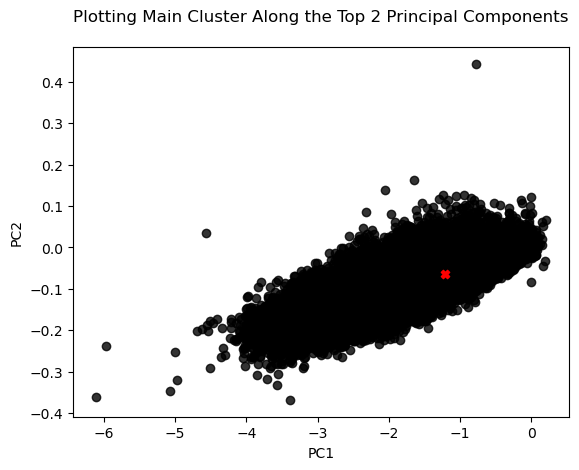

In [4]:
%%time
### View initial points --> Main figure was generated without sampling
pc1_mean, pc2_mean = df.select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]
pd_df = df.select("recon_PC1", "recon_PC2").sample(fraction=0.01).toPandas()

plt.scatter(pd_df["recon_PC1"], pd_df["recon_PC2"], alpha=0.8, color="k")
plt.scatter(pc1_mean, pc2_mean, marker="X", c="r")
plt.title("Plotting Main Cluster Along the Top 2 Principal Components\n")
plt.xlabel("PC1")
plt.ylabel("PC2")


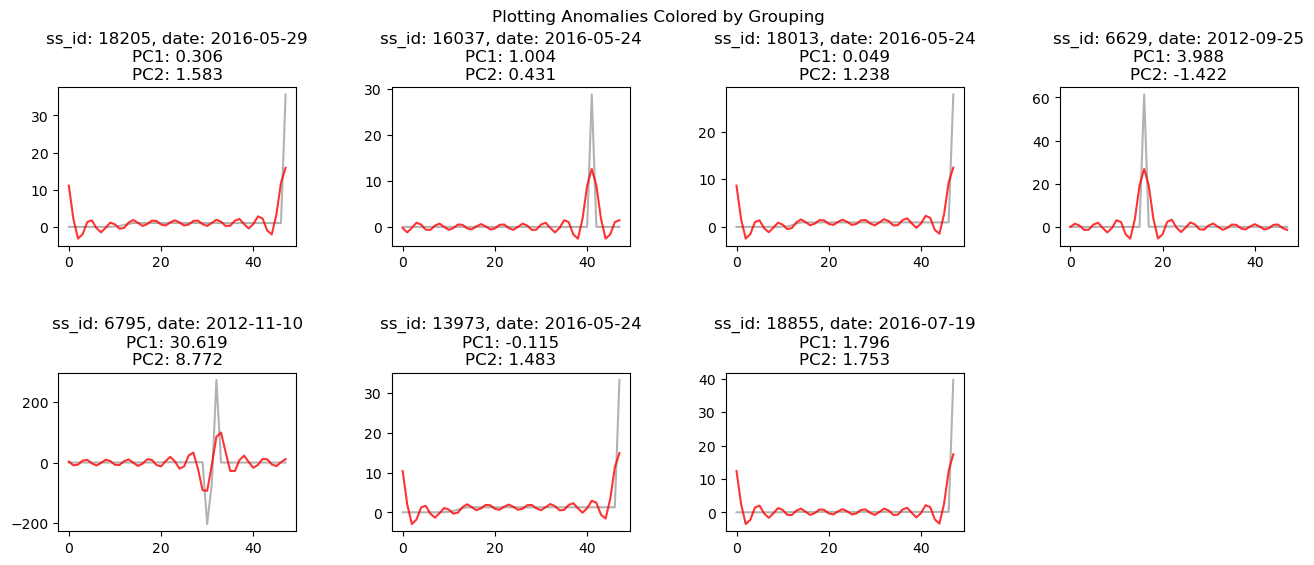

CPU times: user 448 ms, sys: 29.6 ms, total: 477 ms
Wall time: 1.56 s


In [5]:
%%time
### Add a condition to filter out these outliers
cond = (F.col("recon_PC1")>1) | (F.col("recon_PC2")>1)
close_outliers = df.where(cond) \
                   .select("id", "ss_id", "stamp_date", "power_kW_values", "reconstructions", "recon_PC1", "recon_PC2")

pd_df = close_outliers.toPandas()

##############################

### Plotting the anomaly groupings
fig, ax = plt.subplots(2, 4, figsize=(16, 6))
axes = ax.flatten()
for i in np.arange(0,len(pd_df)):
    ss_id = pd_df.loc[i, "ss_id"]
    date = pd_df.loc[i, "stamp_date"]
    recon = pd_df.loc[i, "reconstructions"]
    power = pd_df.loc[i, "power_kW_values"]
    pc1 = np.round(pd_df.loc[i, "recon_PC1"], 3)
    pc2 = np.round(pd_df.loc[i, "recon_PC2"], 3)
    
    x = [i for i in range(0, 48)]
    axes[i].plot(x, power, "k", alpha=0.3)
    axes[i].plot(x, recon, "r", alpha=0.8)
    axes[i].set(title=f"ss_id: {ss_id}, date: {date}\nPC1: {pc1}\nPC2: {pc2}")

axes[7].axis("off")
plt.suptitle("Plotting Anomalies Colored by Grouping")
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=0.85)
plt.tight_layout
plt.show()

pd_df[["id", "ss_id", "stamp_date"]].to_csv("outliers/1_close_outliers.csv", header=True)


In [6]:
%%time
### Filter out these outliers
df2 = df.where(~cond)

CPU times: user 403 µs, sys: 775 µs, total: 1.18 ms
Wall time: 8.95 ms


Text(0, 0.5, 'PC2')

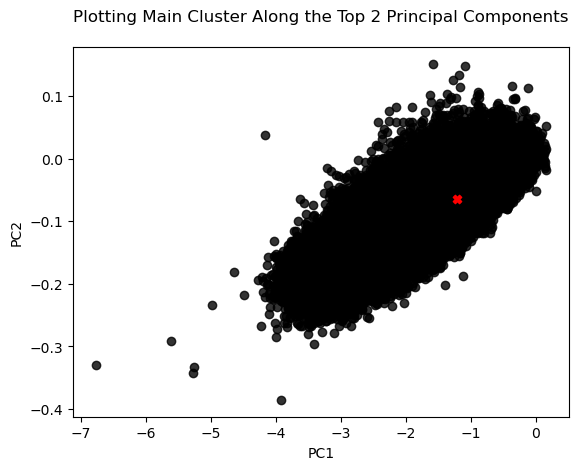

In [7]:
### Plotting results ---> Main figure was generated without sampling
pc1_mean, pc2_mean = df2.select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]
pd_df = df2.select("recon_PC1", "recon_PC2").sample(fraction=0.01).toPandas()

pc1_mean, pc2_mean = pd_df[["recon_PC1", "recon_PC2"]].agg("mean")

# Plot original plot
plt.scatter(pd_df["recon_PC1"], pd_df["recon_PC2"], alpha=0.8, color="k")
plt.scatter(pc1_mean, pc2_mean, marker="X", c="r")
plt.title("Plotting Main Cluster Along the Top 2 Principal Components\n")
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.ylim([10**(-9), 100])




# Locate outliers beyond 1.5 x IQR

One general method for identifying outliers is to define a cutoff in the distribution with regard to one of the variables. Here, outliers will be defined as those beyond Q3 + 1.5\*IQR and Q1 - 1.5\*IQR along either PC1 or PC2 (or both).

In [17]:
%%time
### Find Q1 and Q3 for both recon_PC1 and recon_PC2
quantiles = df2.approxQuantile(["recon_PC1", "recon_PC2"], probabilities=[0.25, 0.75], relativeError=0.001)

pc1_q1 = quantiles[0][0]
pc1_q3 = quantiles[0][1]
pc1_low = pc1_q1 - (1.5*(pc1_q3 - pc1_q1))
pc1_high = pc1_q3 + (1.5*(pc1_q3 - pc1_q1))

pc2_q1 = quantiles[1][0]
pc2_q3 = quantiles[1][1]
pc2_low = pc2_q1 - (1.5*(pc2_q3 - pc2_q1))
pc2_high = pc2_q3 + (1.5*(pc2_q3 - pc2_q1))

print("PC1")
print("Q1:", pc1_q1)
print("Q3:", pc1_q3)
print("IQR:", pc1_q3 - pc1_q1)
print("Low cutoff:", pc1_low)
print("High cutoff:", pc1_high)
print()
print("PC2")
print("Q1:", pc2_q1)
print("Q1:", pc2_q3)
print("IQR:", pc2_q3 - pc2_q1)
print("Low cutoff:", pc2_low)
print("High cutoff:", pc2_high)

df2_stats = df2.withColumn("IQR_PC1_high", 
                            F.when(F.col("recon_PC1") > pc1_high, 1).otherwise(0)) \
                .withColumn("IQR_PC1_low", 
                            F.when(F.col("recon_PC1") < pc1_low, 1).otherwise(0)) \
                .withColumn("IQR_PC2_high", 
                            F.when(F.col("recon_PC2") > pc2_high, 1).otherwise(0)) \
                .withColumn("IQR_PC2_low", 
                            F.when(F.col("recon_PC2") < pc2_low, 1).otherwise(0))

results = df2_stats.select(F.sum("IQR_PC1_low"),
                           F.sum("IQR_PC1_high"),
                           F.sum("IQR_PC2_low"),
                           F.sum("IQR_PC2_high")
                           ).collect()[0]

IQR_results = {"count_PC1_low": results[0],
               "count_PC1_high": results[1],
               "count_PC2_low": results[2],
               "count_PC2_high": results[3]}

print()
print("Number of low PC1 outliers:", IQR_results["count_PC1_low"])
print("Number of high PC1 outliers:", IQR_results["count_PC1_high"])
print("Number of low PC2 outliers:", IQR_results["count_PC2_low"])
print("Number of high PC2 outliers:", IQR_results["count_PC2_high"])
print()

df2_stats.where((F.col("IQR_PC1_high")==1) |
                (F.col("IQR_PC1_low")==1) |
                (F.col("IQR_PC2_high")==1) |
                (F.col("IQR_PC2_low")==1)) \
         .select("id", "ss_id", "stamp_date", "IQR_PC1_high", "IQR_PC1_low", "IQR_PC2_high", "IQR_PC2_low") \
         .toPandas() \
         .to_csv("outliers/2_IQR_outliers.csv", index=False, header=True)

PC1
Q1: -1.8238174771682876
Q3: -0.4793460083736114
IQR: 1.3444714687946762
Low cutoff: -3.8405246803603017
High cutoff: 1.5373611948184027

PC2
Q1: -0.0981542917949552
Q1: -0.022772873468713744
IQR: 0.07538141832624146
Low cutoff: -0.2112264192843174
High cutoff: 0.09029925402064844

Number of low PC1 outliers: 16108
Number of high PC1 outliers: 0
Number of low PC2 outliers: 93105
Number of high PC2 outliers: 2463

CPU times: user 650 ms, sys: 22.3 ms, total: 672 ms
Wall time: 46 s


In [9]:
### Getting data for plotting
df2_outliers = df2_stats.where((F.col("IQR_PC1_high")==1) |
                                (F.col("IQR_PC1_low")==1) |
                                (F.col("IQR_PC2_high")==1) |
                                (F.col("IQR_PC2_low")==1)) \
                         .select("id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2", "IQR_PC1_high", "IQR_PC1_low", "IQR_PC2_high", "IQR_PC2_low") \
                         .toPandas()
df2_normal = df2_stats.select("recon_PC1", "recon_PC2") \
                      .toPandas()

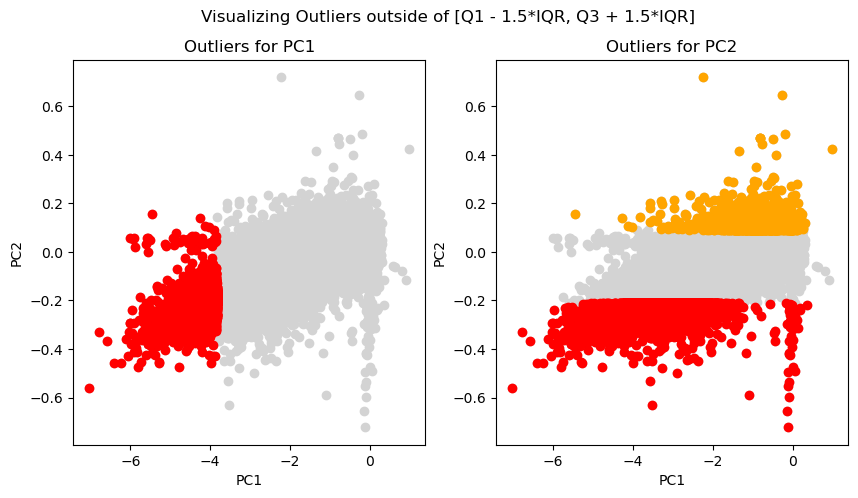

In [10]:
df2_normal2 = df2_normal
pc1_outliers_low = df2_outliers[df2_outliers["IQR_PC1_low"]==1]
# pc1_outliers_high = df2_outliers[df2_outliers["IQR_PC1_high"]==1]
pc2_outliers_low = df2_outliers[df2_outliers["IQR_PC2_low"]==1]
pc2_outliers_high = df2_outliers[df2_outliers["IQR_PC2_high"]==1]


fig,ax = plt.subplots(1,2, figsize=(10,5))
#
ax[0].plot(df2_normal2["recon_PC1"], df2_normal2["recon_PC2"], "o", color="lightgrey")
ax[0].plot(pc1_outliers_low["recon_PC1"], pc1_outliers_low["recon_PC2"], "o", color="r")
# ax[0].plot(pc1_outliers_high["recon_PC1"], pc1_outliers_high["recon_PC2"], "o", color="orange")
ax[0].set(title="Outliers for PC1", xlabel="PC1", ylabel="PC2") 
#
ax[1].plot(df2_normal2["recon_PC1"], df2_normal2["recon_PC2"], "o", color="lightgrey")
ax[1].plot(pc2_outliers_low["recon_PC1"], pc2_outliers_low["recon_PC2"], "o", color="r")
ax[1].plot(pc2_outliers_high["recon_PC1"], pc2_outliers_high["recon_PC2"], "o", color="orange")
ax[1].set(title="Outliers for PC2", xlabel="PC1", ylabel="PC2") 
plt.suptitle("Visualizing Outliers outside of [Q1 - 1.5*IQR, Q3 + 1.5*IQR]")
plt.show()

In [42]:
### Plotting the average curves
assemble_power = VectorAssembler(inputCols = [f"power_kW_values[{i}]" for i in range(0,48)], outputCol="power_kW_values2")
assemble_recon = VectorAssembler(inputCols = [f"reconstructions[{i}]" for i in range(0,48)], outputCol="reconstructions2")

df_pc1_low = df.select("id", "power_kW_values", "reconstructions") \
               .where(F.col("recon_PC1") < pc1_low)
df_pc1_normal = df.select("id", "power_kW_values", "reconstructions") \
                  .where(F.col("recon_PC1") >= pc1_low)
df_pc2_low = df.select("id", "power_kW_values", "reconstructions") \
               .where(F.col("recon_PC2") < pc2_low) 
df_pc2_high = df.select("id", "power_kW_values", "reconstructions") \
                .where(F.col("recon_PC2") > pc2_low) 
df_pc2_normal = df.select("id", "power_kW_values", "reconstructions") \
                  .where((F.col("recon_PC2") >= pc2_low) & (F.col("recon_PC2") <= pc2_high))

### Calculate normal curve mean power/recon
df_pc1_normal = assemble_power.transform(df_pc1_normal.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc1_normal = assemble_recon.transform(df_pc1_normal.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc1_normal = df_pc1_normal.select("id", "power_kW_values2", "reconstructions2")
# pc1_normal_mean_powers = list(df_pc1_normal.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc1_normal_mean_recons = list(df_pc1_normal.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

df_pc2_normal = assemble_power.transform(df_pc2_normal.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc2_normal = assemble_recon.transform(df_pc2_normal.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc2_normal = df_pc2_normal.select("id", "power_kW_values2", "reconstructions2")
# pc2_normal_mean_powers = list(df_pc2_normal.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc2_normal_mean_recons = list(df_pc2_normal.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

### Calculate outlier curve mean power/recon
df_pc1_low = assemble_power.transform(df_pc1_low.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc1_low = assemble_recon.transform(df_pc1_low.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc1_low = df_pc1_low.select("id", "power_kW_values2", "reconstructions2")
# pc1_low_mean_powers = list(df_pc1_low.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc1_low_mean_recons = list(df_pc1_low.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

df_pc2_low = assemble_power.transform(df_pc2_low.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc2_low = assemble_recon.transform(df_pc2_low.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc2_low = df_pc2_low.select("id", "power_kW_values2", "reconstructions2")
# pc2_low_mean_powers = list(df_pc2_low.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc2_low_mean_recons = list(df_pc2_low.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

df_pc2_high = assemble_power.transform(df_pc2_high.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc2_high = assemble_recon.transform(df_pc2_high.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc2_high = df_pc2_high.select("id", "power_kW_values2", "reconstructions2")
# pc2_high_mean_powers = list(df_pc2_high.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc2_high_mean_recons = list(df_pc2_high.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

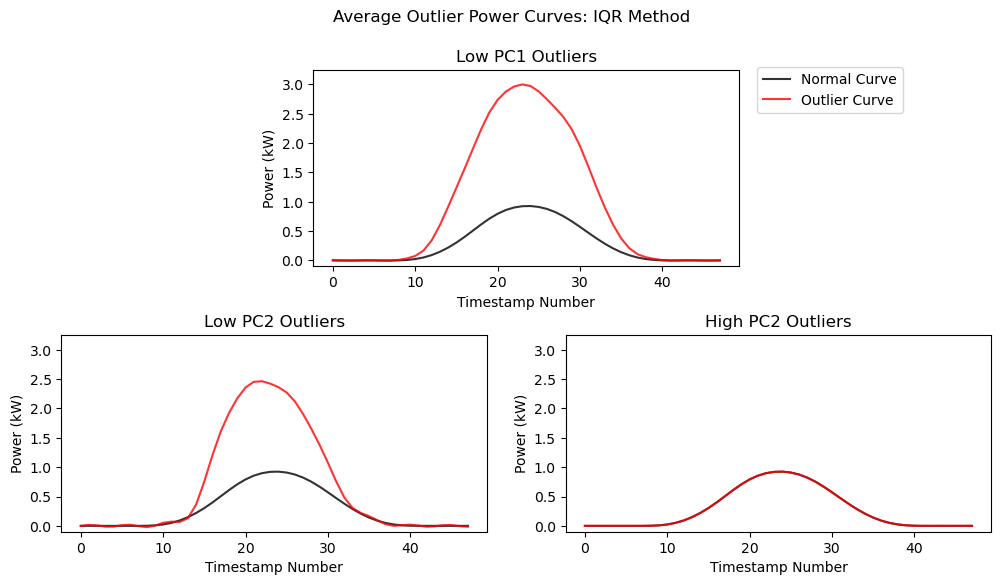

In [58]:
### Plot average curves vs normal curves
x = [i for i in np.arange(0,48)]

# Setting up the gridspec subplots
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2,4, wspace=0.45, hspace=0.35)

plot1 = fig.add_subplot(grid[0,1:3])
plot2 = fig.add_subplot(grid[1,0:2])
plot3 = fig.add_subplot(grid[1,2:])

# PC1 low outliers
plot1.plot(x, pc1_normal_mean_recons, "k", alpha=0.8, label="Normal Curve")
plot1.plot(x, pc1_low_mean_recons, "r", alpha=0.8, label="Outlier Curve")
plot1.legend(loc="upper right", bbox_to_anchor=([1.4, 1.05]))
plot1.set(xlabel="Timestamp Number", ylabel="Power (kW)", title="Low PC1 Outliers", ylim=[-.1, 3.25])
# PC2 low outliers 
plot2.plot(x, pc2_normal_mean_recons, "k", alpha=0.8)
plot2.plot(x, pc2_low_mean_recons, "r", alpha=0.8)
plot2.set(xlabel="Timestamp Number", ylabel="Power (kW)", title="Low PC2 Outliers", ylim=[-.1, 3.25])
# PC2 High outliers 
plot3.plot(x, pc2_normal_mean_recons, "k", alpha=0.8)
plot3.plot(x, pc2_high_mean_recons, "r", alpha=0.8)
plot3.set(xlabel="Timestamp Number", ylabel="Power (kW)", title="High PC2 Outliers", ylim=[-.1, 3.25])

plt.suptitle("Average Outlier Power Curves: IQR Method")
plt.show()

# Locate outliers beyond 3 standard deviations of the mean

Another general method for identifying outliers is to define a cutoff as instances with a variable value outside of 3 standard deviations of the mean. Assuming that the data has a normal distribution, 99.7% of the instances should lie within this boundary range.

In [60]:
%%time
### Find mean and standard deviation for both recon_PC1 and recon_PC2
values = df2.select(F.avg("recon_PC1"), F.avg("recon_PC2"), F.std("recon_PC1"), F.std("recon_PC2")).collect()

pc1_mean = values[0][0]
pc1_std = values[0][2]
pc1_low = pc1_mean - (3*pc1_std)
pc1_high = pc1_mean + (3*pc1_std)

pc2_mean = values[0][1]
pc2_std = values[0][3]
pc2_low = pc2_mean - (3*pc2_std)
pc2_high = pc2_mean + (3*pc2_std)

print("PC1")
print("Mean:", pc1_mean)
print("Std:", pc1_std)
print("Low cutoff:", pc1_low)
print("High cutoff:", pc1_high)
print()
print("PC2")
print("Mean:", pc2_mean)
print("Std:", pc2_std)
print("Low cutoff:", pc1_low)
print("High cutoff:", pc1_high)

df2_stats = df2.withColumn("STD_PC1_high", 
                            F.when(F.col("recon_PC1") > pc1_high, 1).otherwise(0)) \
                .withColumn("STD_PC1_low", 
                            F.when(F.col("recon_PC1") < pc1_low, 1).otherwise(0)) \
                .withColumn("STD_PC2_high", 
                            F.when(F.col("recon_PC2") > pc2_high, 1).otherwise(0)) \
                .withColumn("STD_PC2_low", 
                            F.when(F.col("recon_PC2") < pc2_low, 1).otherwise(0))

results = df2_stats.select(F.sum("STD_PC1_low"),
                           F.sum("STD_PC1_high"),
                           F.sum("STD_PC2_low"),
                           F.sum("STD_PC2_high")
                           ).collect()[0]

IQR_results = {"count_PC1_low": results[0],
               "count_PC1_high": results[1],
               "count_PC2_low": results[2],
               "count_PC2_high": results[3]}

print()
print("Number of low PC1 outliers:", IQR_results["count_PC1_low"])
print("Number of high PC1 outliers:", IQR_results["count_PC1_high"])
print("Number of low PC2 outliers:", IQR_results["count_PC2_low"])
print("Number of high PC2 outliers:", IQR_results["count_PC2_high"])
print()

df2_stats.where((F.col("recon_PC1")==1) |
                (F.col("recon_PC1")==1) |
                (F.col("recon_PC2")==1) |
                (F.col("recon_PC2")==1)) \
         .select("id", "ss_id", "stamp_date", "STD_PC1_high", "STD_PC1_low", "STD_PC2_high", "STD_PC2_low") \
         .toPandas() \
         .to_csv("outliers/3_STD_outliers.csv", header=True)


PC1
Mean: -1.2105306403713902
Std: 0.8505128709916235
Low cutoff: -3.7620692533462607
High cutoff: 1.3410079726034805

PC2
Mean: -0.06401736026457593
Std: 0.04957997123182802
Low cutoff: -3.7620692533462607
High cutoff: 1.3410079726034805

Number of low PC1 outliers: 26770
Number of high PC1 outliers: 0
Number of low PC2 outliers: 84879
Number of high PC2 outliers: 3186

CPU times: user 19 ms, sys: 4.95 ms, total: 24 ms
Wall time: 42.7 s


In [62]:
### Get pandas plots
df_STD_outliers = df2_stats.where((F.col("recon_PC1")>pc1_low) | \
                                  (F.col("recon_PC1")<pc1_high) | \
                                  (F.col("recon_PC2")>pc2_low) | \
                                  (F.col("recon_PC2")<pc2_high)) \
                            .select("recon_PC1", "recon_PC2", "STD_PC1_high", "STD_PC1_low", "STD_PC2_high", "STD_PC2_low")

df2_normal = df2_stats.select("recon_PC1", "recon_PC2") \
                      .toPandas()

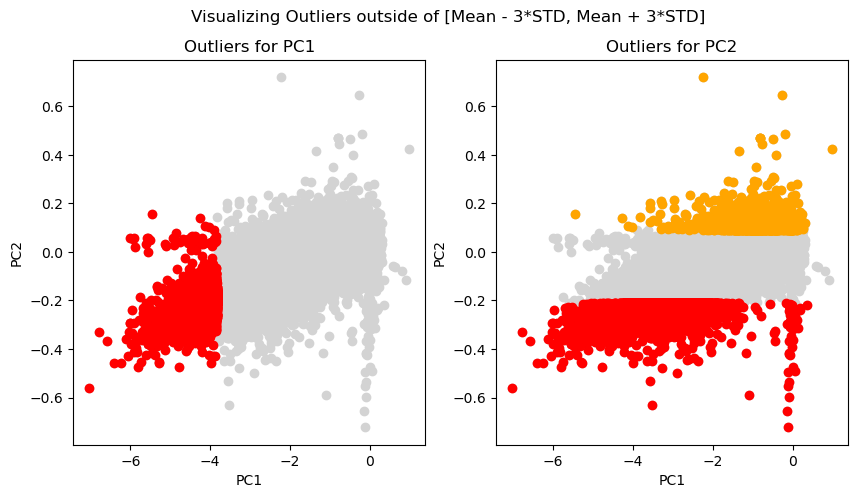

In [63]:
df2_normal2 = df2_normal
pc1_outliers_low = df2_outliers[df2_outliers["IQR_PC1_low"]==1]
# pc1_outliers_high = df2_outliers[df2_outliers["IQR_PC1_high"]==1]
pc2_outliers_low = df2_outliers[df2_outliers["IQR_PC2_low"]==1]
pc2_outliers_high = df2_outliers[df2_outliers["IQR_PC2_high"]==1]

fig,ax = plt.subplots(1,2, figsize=(10,5))
#
ax[0].plot(df2_normal2["recon_PC1"], df2_normal2["recon_PC2"], "o", color="lightgrey")
ax[0].plot(pc1_outliers_low["recon_PC1"], pc1_outliers_low["recon_PC2"], "o", color="r")
# ax[0].plot(pc1_outliers_high["recon_PC1"], pc1_outliers_high["recon_PC2"], "o", color="orange")
ax[0].set(title="Outliers for PC1", xlabel="PC1", ylabel="PC2") 
#
ax[1].plot(df2_normal2["recon_PC1"], df2_normal2["recon_PC2"], "o", color="lightgrey")
ax[1].plot(pc2_outliers_low["recon_PC1"], pc2_outliers_low["recon_PC2"], "o", color="r")
ax[1].plot(pc2_outliers_high["recon_PC1"], pc2_outliers_high["recon_PC2"], "o", color="orange")
ax[1].set(title="Outliers for PC2", xlabel="PC1", ylabel="PC2") 
plt.suptitle("Visualizing Outliers outside of [Mean - 3*STD, Mean + 3*STD]")
plt.show()

In [64]:
### Plotting the average curves
assemble_power = VectorAssembler(inputCols = [f"power_kW_values[{i}]" for i in range(0,48)], outputCol="power_kW_values2")
assemble_recon = VectorAssembler(inputCols = [f"reconstructions[{i}]" for i in range(0,48)], outputCol="reconstructions2")

df_pc1_low = df.select("id", "power_kW_values", "reconstructions") \
               .where(F.col("recon_PC1") < pc1_low)
df_pc1_normal = df.select("id", "power_kW_values", "reconstructions") \
                  .where(F.col("recon_PC1") >= pc1_low)
df_pc2_low = df.select("id", "power_kW_values", "reconstructions") \
               .where(F.col("recon_PC2") < pc2_low) 
df_pc2_high = df.select("id", "power_kW_values", "reconstructions") \
                .where(F.col("recon_PC2") > pc2_low) 
df_pc2_normal = df.select("id", "power_kW_values", "reconstructions") \
                  .where((F.col("recon_PC2") >= pc2_low) & (F.col("recon_PC2") <= pc2_high))

### Calculate normal curve mean power/recon
df_pc1_normal = assemble_power.transform(df_pc1_normal.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc1_normal = assemble_recon.transform(df_pc1_normal.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc1_normal = df_pc1_normal.select("id", "power_kW_values2", "reconstructions2")
# pc1_normal_mean_powers = list(df_pc1_normal.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc1_normal_mean_recons = list(df_pc1_normal.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

df_pc2_normal = assemble_power.transform(df_pc2_normal.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc2_normal = assemble_recon.transform(df_pc2_normal.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc2_normal = df_pc2_normal.select("id", "power_kW_values2", "reconstructions2")
# pc2_normal_mean_powers = list(df_pc2_normal.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc2_normal_mean_recons = list(df_pc2_normal.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

### Calculate outlier curve mean power/recon
df_pc1_low = assemble_power.transform(df_pc1_low.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc1_low = assemble_recon.transform(df_pc1_low.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc1_low = df_pc1_low.select("id", "power_kW_values2", "reconstructions2")
# pc1_low_mean_powers = list(df_pc1_low.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc1_low_mean_recons = list(df_pc1_low.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

df_pc2_low = assemble_power.transform(df_pc2_low.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc2_low = assemble_recon.transform(df_pc2_low.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc2_low = df_pc2_low.select("id", "power_kW_values2", "reconstructions2")
# pc2_low_mean_powers = list(df_pc2_low.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc2_low_mean_recons = list(df_pc2_low.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

df_pc2_high = assemble_power.transform(df_pc2_high.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_pc2_high = assemble_recon.transform(df_pc2_high.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_pc2_high = df_pc2_high.select("id", "power_kW_values2", "reconstructions2")
# pc2_high_mean_powers = list(df_pc2_high.select(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
pc2_high_mean_recons = list(df_pc2_high.select(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

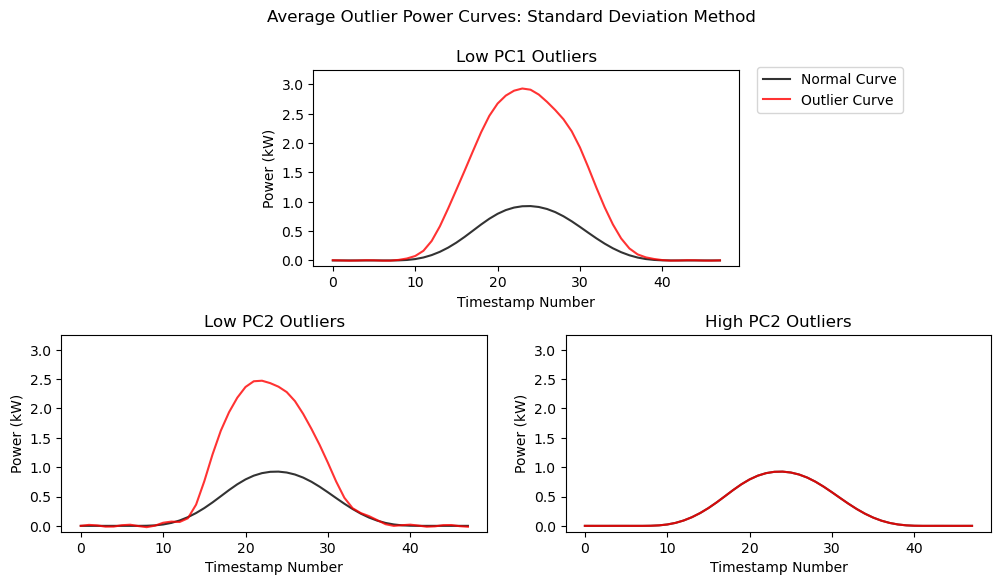

In [65]:
### Plot average curves vs normal curves
x = [i for i in np.arange(0,48)]

# Setting up the gridspec subplots
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2,4, wspace=0.45, hspace=0.35)

plot1 = fig.add_subplot(grid[0,1:3])
plot2 = fig.add_subplot(grid[1,0:2])
plot3 = fig.add_subplot(grid[1,2:])

# PC1 low outliers
plot1.plot(x, pc1_normal_mean_recons, "k", alpha=0.8, label="Normal Curve")
plot1.plot(x, pc1_low_mean_recons, "r", alpha=0.8, label="Outlier Curve")
plot1.legend(loc="upper right", bbox_to_anchor=([1.4, 1.05]))
plot1.set(xlabel="Timestamp Number", ylabel="Power (kW)", title="Low PC1 Outliers", ylim=[-.1, 3.25])
# PC2 low outliers 
plot2.plot(x, pc2_normal_mean_recons, "k", alpha=0.8)
plot2.plot(x, pc2_low_mean_recons, "r", alpha=0.8)
plot2.set(xlabel="Timestamp Number", ylabel="Power (kW)", title="Low PC2 Outliers", ylim=[-.1, 3.25])
# PC2 High outliers 
plot3.plot(x, pc2_normal_mean_recons, "k", alpha=0.8)
plot3.plot(x, pc2_high_mean_recons, "r", alpha=0.8)
plot3.set(xlabel="Timestamp Number", ylabel="Power (kW)", title="High PC2 Outliers", ylim=[-.1, 3.25])

plt.suptitle("Average Outlier Power Curves: Standard Deviation Method")
plt.show()